# Bibliotecas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from datetime import datetime, time

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print ("Início Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Início Execução : 
2021-07-25 19:24:57


# Funções Auxiliares

In [4]:
def get_dados(path, numero_frutas):
    lista_dir = os.listdir(path)
    X = []
    Y = []
    classes = []
    fruta_num = 0
    passo = len(lista_dir)/numero_frutas
    for idx, fruta in enumerate(lista_dir):
        if (idx % passo != 0):
            continue
        lista_img = os.listdir(f"{path}/{fruta}")
        classes.append(fruta)
        print(f"{fruta_num} - {idx} - {fruta} - {len(lista_img)}")
        for img in lista_img:
            arquivo = f"{path}/{fruta}/{img}"
            img_fruta = img_to_array(load_img(arquivo, target_size=(32, 32)))
            X.append(img_fruta)
            Y.append(fruta_num)
        fruta_num = fruta_num + 1    
    return (X, Y, classes)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Carregando os dados

In [5]:
# número de frutas a serem usadas neste notebook
num_frutas = 15

In [6]:
# diretórios das imagens
path_treino = './data/frutas/Training' 
path_teste = './data/frutas/Test'

In [7]:
# carregando as imagens com tamanho 32x32 (para a LENET5) e os labels em memória
X_frutas, Y_frutas, frutas_labels = get_dados(path_treino, num_frutas)

0 - 0 - Apple Braeburn - 492


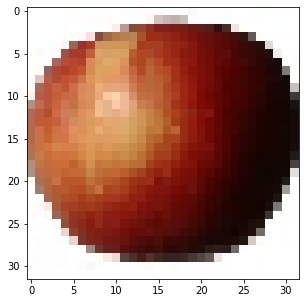

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(array_to_img(X_frutas[0]))

In [ ]:
Y_frutas[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Temos uma distribuição quase uniforme das respostas, apenas 4 com um pouco a mais.

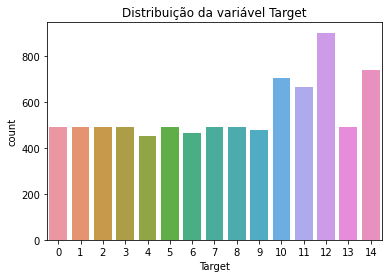

In [ ]:
sns.countplot(x = Y_frutas)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks()
plt.show()

In [ ]:
len(X_frutas)

8329

In [ ]:
len(Y_frutas)

8329

In [ ]:
X = np.asarray(X_frutas).astype(np.float32)
Y = np.asarray(Y_frutas)

## Padronizando os dados, que estão entre 0 e 255, dividindo por 255.
### Dados padronizados entre 0 e 1.

In [ ]:
X = X/255
X.shape

(8329, 32, 32, 3)

## Transformando a variável resposta em "One-hot vector" para utilizá-la no modelo de MLP

In [ ]:
Y = to_categorical(Y, num_frutas)
Y.shape

(8329, 15)

In [ ]:
Y[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

## Dividindo a Base de Dados de treino entre treino e validação, com 20% para a validação.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Modelo de MLP

## Criando o modelo Lenet5 padrão com funçaõ de ativação "relu".

In [ ]:
# Cria o modelo
model = Sequential()
model.add(Conv2D(6, (5, 5), input_shape=(32, 32, 3), activation='relu'))    
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
model.add(Conv2D(16, (5, 5), activation='relu'))  
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(84, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(num_frutas, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_5 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True)

## Compilando e treinando o modelo. 
### Vamos utilizar a função de Callback ModelCheckPointer para salvar o modelo com a melhor accuracia na base de validação.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex8_1.hdf5', verbose=1,  save_best_only=True, monitor='val_accuracy')

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, batch_size=32, callbacks=[checkpointer], verbose=1)

## Gráfico comparativo da Acurácia e Perda no treinamento

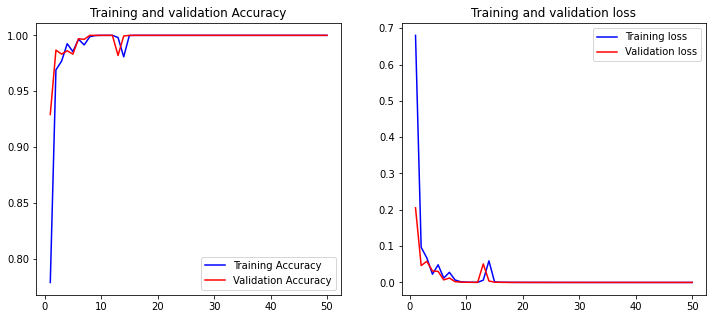

In [ ]:
plot_history(history)

## Apresentando a Acurácia final do Treino, carregando o melhor modelo salvo e apresentando a Acurácia da Validação.

In [ ]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acuracia do Treino: {round(scores[1]*100,2)}%")

209/209 [==============================] - 0s 2ms/step - loss: 1.6814e-06 - accuracy: 1.0000

Acuracia do Treino: 100.0%


In [ ]:
model = load_model("./modelo_mlp_ex8_1.hdf5")

In [ ]:
scores = model.evaluate(X_val, y_val)
print()
print(f"Acuracia da validação: {round(scores[1]*100,2)}%")

53/53 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000

Acuracia da validação: 100.0%


## Carregando os dados para o Teste e aplicando os mesmos pré processamentos

In [ ]:
X_frutas, Y_frutas, frutas_labels = get_dados(path_teste, num_frutas)

0 - 0 - Apple Braeburn - 164
1 - 8 - Apple Red 2 - 164
2 - 16 - Banana - 166
3 - 24 - Carambula - 166
4 - 32 - Chestnut - 153
5 - 40 - Grape Pink - 164
6 - 48 - Hazelnut - 157
7 - 56 - Limes - 166
8 - 64 - Mulberry - 164
9 - 72 - Orange - 160
10 - 80 - Pear Forelle - 234
11 - 88 - Pepper Yellow - 222
12 - 96 - Plum 3 - 304
13 - 104 - Rambutan - 164
14 - 112 - Tomato 1 - 246


In [ ]:
X_test = np.asarray(X_frutas).astype(np.float32)
y_test = np.asarray(Y_frutas)

In [ ]:
X_test = X_test/255
y_test = to_categorical(y_test, num_frutas)

In [ ]:
X_test.shape

(2794, 32, 32, 3)

In [ ]:
y_test.shape

(2794,)

## Apresentando a Acurácia do Teste

In [ ]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acuracia do Teste: {round(scores[1]*100,2)}%")

88/88 [==============================] - 0s 2ms/step - loss: 0.1552 - accuracy: 0.9571

Acuracia do Teste: 95.71%


## Conseguimos um resultado de mais de 95% no teste usando uma LENET5 padrão. Além de um treinamento muito rápido.

## Demostração aleatória de algumas previsões do modelo. 
### Verde = previsão correta
### Vermelho = previsão errada

In [ ]:
y_hat = model.predict(X_test)

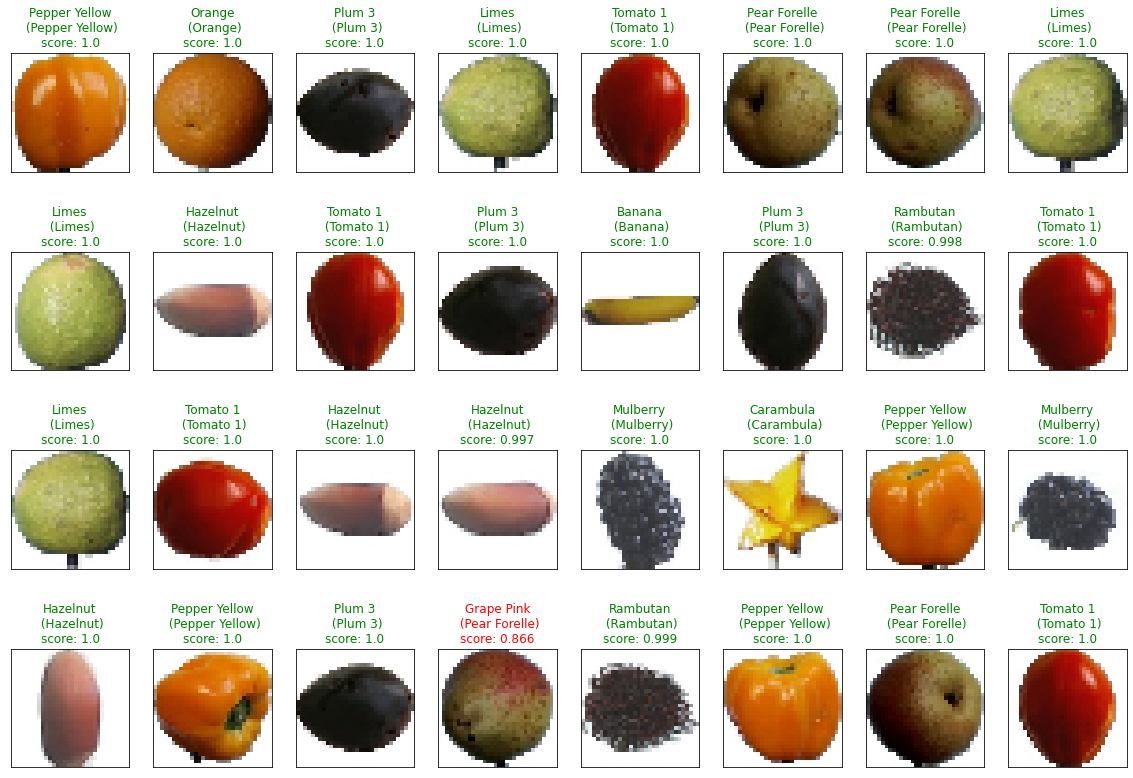

In [ ]:
fig = plt.figure(figsize=(20, 14))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    pred_proba = y_hat[idx][pred_idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{}\n ({})\nscore: {:.3}".format(frutas_labels[pred_idx], frutas_labels[true_idx], pred_proba),
                 color=("green" if pred_idx == true_idx else "red"))
    # amostras corretamente classificadas em verde, incorretamente classificadas em vermelho


In [ ]:
print ("Fim Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))